## But actually, we want to analyze repos 

In [84]:
import os
import numpy as numpy
import matplotlib.pyplot as pyplot
from git import Repo 
from datetime import datetime
import matplotlib as matplotlib
import subprocess
import time
from git.db import GitCmdObjectDB
from git.db import GitDB

In [1]:
from repoLibrarian import *

In [119]:
repo = Repo.init('scylla.git', bare=True, odbt=GitDB)

## Classes over time

Time used: 2.3841774463653564


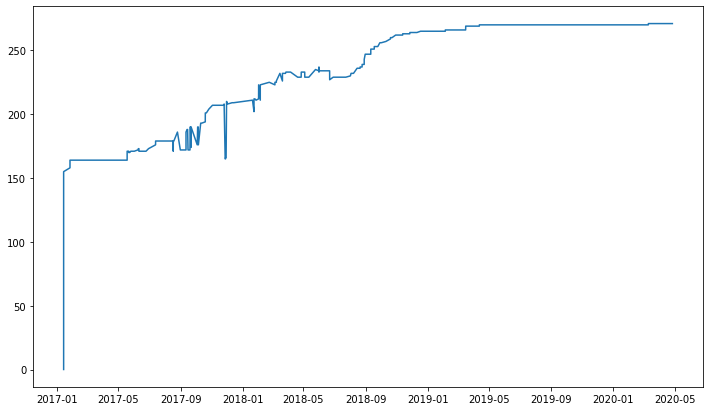

In [3]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            fileCount = fileCount + 1
    fileCounts.append(fileCount)
end = time.time()
print('Time used: '+str(end - start))
    
dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

## Test classes over time

Time used: 2.4306929111480713


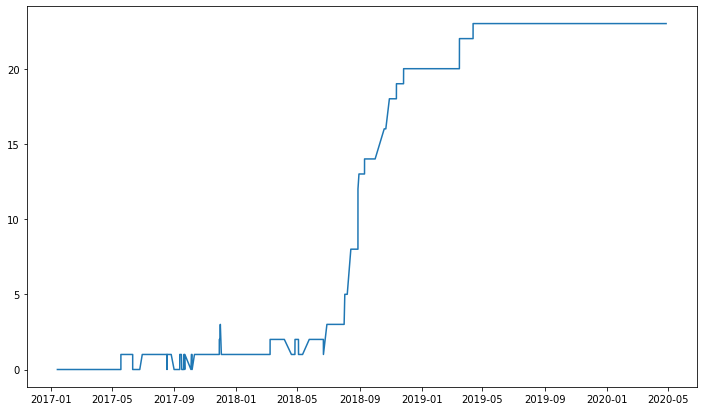

In [4]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java') and ('Test' in obj.name):
            fileCount = fileCount + 1
    fileCounts.append(fileCount)
end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

## Print the srcml contents of a single file
git --git-dir="./Scylla.git" show ee00a205a2225ad73b0264cf7ba64be5c7044d0b:src/main/java/de/hpi/bpt/scylla/Scylla.java | xargs -0 srcml -l Java --text

In [5]:
commit = repo.active_branch.commit
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java') and obj.name == 'Scylla.java':
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        print(content)
        

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<unit xmlns="http://www.srcML.org/srcML/src" revision="0.9.5" language="Java"><package>package <name><name>de</name><operator>.</operator><name>hpi</name><operator>.</operator><name>bpt</name><operator>.</operator><name>scylla</name></name>;</package>

<import>import <name><name>java</name><operator>.</operator><name>util</name><operator>.</operator><name>Arrays</name></name>;</import>

<comment type="block" format="javadoc">/**
 * Scylla is an extensible simulator for business processes in BPMN. &lt;br&gt;
 * This class initializes and runs the {@link SimulationManager} which simulates the processes based on the given input.
 * 
 * @author Tsun Yin Wong
 *
 */</comment>
<class><specifier>public</specifier> class <name>Scylla</name> <block>{
    <decl_stmt><decl><specifier>public</specifier> <specifier>static</specifier> <type><specifier>final</specifier> <name>String</name></type> <name>OS</name> <init>= <expr><call><name><name>S

# Combine gitpython and srcml

## Naive approach to calculate LoC over time

Time used: 6358.601209163666


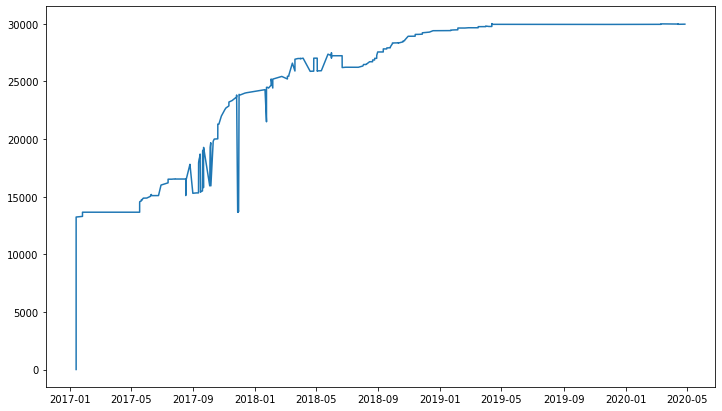

In [6]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
            fileCount = fileCount + len(content.split('\n'))
    fileCounts.append(fileCount)

end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

#### And now for average LoC per File:

In [ ]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    lineCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 -I $ srcml -l Java --text $ | wc -l' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
            lineCount = lineCount + int(content)
            fileCount = fileCount + 1
    if fileCount == 0:
        fileCounts.append(0)
    else:
        fileCounts.append(lineCount / fileCount)

end = time.time()

Time used: 7572.929245471954


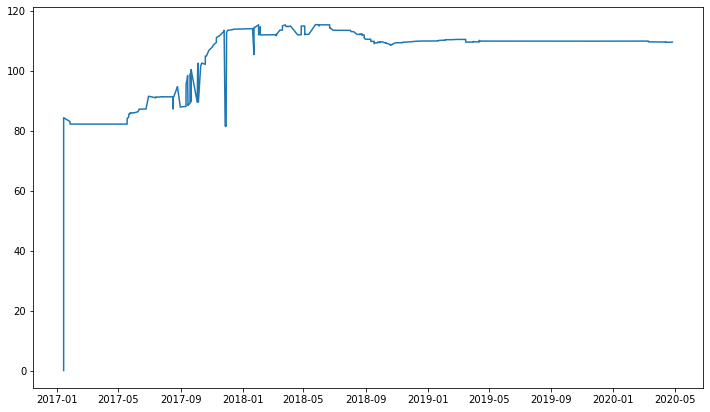

In [52]:
print('Time used: '+str(end - start))
dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

### Tuning file traversal speed
* Calculating LoC for one single commit takes already very long!
* Removing the xargs to srcml does not change time significally
* Checking out improves time; but not enough that I would accept

=> Number of git shows must be reduced

In [70]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 srcml -l Java --text' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29976
Time used: 27.469611644744873


So let's try using wc

In [86]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla.git" show %s:%s | xargs -0 -I $ srcml -l Java --text $ | wc -l' % (commit.hexsha, obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + int(content)
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29705
Time used: 26.598869562149048


Or let's try checkouted repos ...

In [57]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = subprocess.check_output('git --git-dir="./scylla" show %s' % (obj.path), shell=True).decode("utf-8")
        lineCount = lineCount + int(content)
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

CalledProcessError: Command 'git --git-dir="./scylla" show src/main/java/de/hpi/bpt/scylla/Scylla.java' returned non-zero exit status 128.

Using Toni's Tip: (Thanks!)

In [87]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        with subprocess.Popen(['srcml', '-l', 'Java'], stdin=subprocess.PIPE, stdout=subprocess.PIPE) as srcml:
            srcml.stdin.write(obj.data_stream.read())
            srcml.stdin.close() 
            content = srcml.stdout.read().decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29967
Time used: 23.731434106826782


In [116]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = obj.data_stream.read().decode("utf-8")
        lineCount = lineCount + len(content.split('\n'))
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29423
Time used: 0.07674717903137207


In [76]:
start = time.time()
commit = repo.active_branch.commit
lineCount = 0
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        content = os.popen('git --git-dir="./scylla.git" show %s:%s | xargs -0 -I $ srcml -l Java --text $ | wc -l' % (commit.hexsha, obj.path)).read()
        lineCount = lineCount + int(content)
print(lineCount)
end = time.time()
print('Time used: '+str(end - start))

29705
Time used: 27.872111558914185


Time used: 20.215256214141846


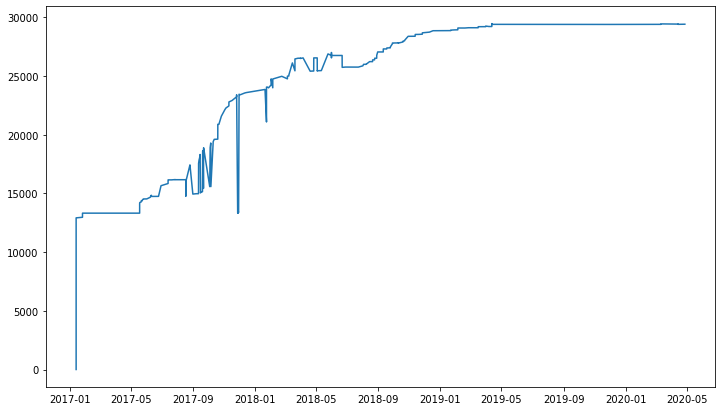

In [120]:
timestamps = list(map(lambda commit: datetime.fromtimestamp(commit.committed_date), repo.iter_commits()))
fileCounts = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            content = obj.data_stream.read().decode("utf-8")
            fileCount = fileCount + len(content.split('\n'))
    fileCounts.append(fileCount)

end = time.time()
print('Time used: '+str(end - start))

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, fileCounts, '-')

## Working: LoC/Method With Regex 

Time used: 42.52645564079285


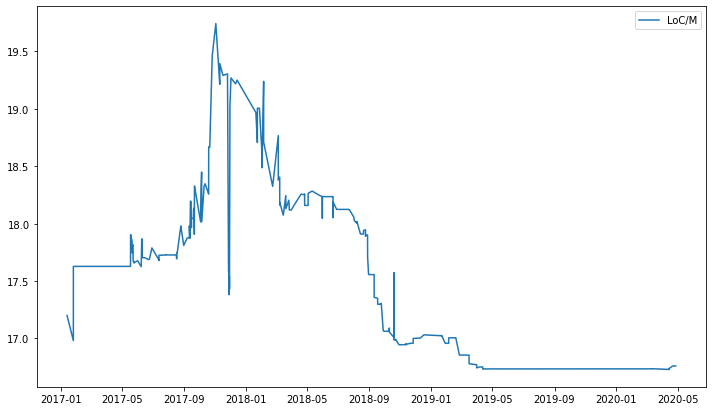

In [148]:
import re
commit = repo.active_branch.commit
classRegex = re.compile(r"class")
methodRegex = re.compile(r"(public|protected|private|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\) *(\{?|[^;])")

timestamps = []
metrics = []

start = time.time()
for commit in repo.iter_commits():
    fileCount = 0
    aggregatedMetric = 0
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            fileCount = fileCount + 1
            contentWithHeader = obj.data_stream.read().decode("utf-8")
            content = contentWithHeader.split('{', 1)[1]
            numMethods = len(methodRegex.findall(content))
            loc = len(content.split('\n'))
            metric = loc / numMethods if numMethods > 0 else 0
            aggregatedMetric = aggregatedMetric + metric
    metrics.append(aggregatedMetric/fileCount if fileCount > 0 else 0)
    timestamps.append(datetime.fromtimestamp(commit.committed_date))

end = time.time()
print('Time used: '+str(end - start))

metrics.pop()
timestamps.pop()

dates = matplotlib.dates.date2num(timestamps)
pyplot.figure(figsize=(12, 7))
pyplot.plot_date(dates, metrics, '-')
pyplot.legend(['LoC/M'])

---
# Generalization for metrics

In [1]:
import re
import matplotlib.pyplot as pyplot
import matplotlib
import time
from datetime import datetime

In [2]:
%load_ext autoreload
from repoLibrarian import *
%aimport repoLibrarian
%autoreload

In [3]:
setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [132]:
getReposFolder()

'/mnt/brick/crm20/repos/'

In [3]:
def safeDivision(a,b):
    return a/b if b > 0 else 0

In [4]:
def removeHeader(contentWithHeader):
    content = contentWithHeader.split('{', 1)
    content = content[1] if len(content) > 1 else ''
    return content

In [5]:
def occurencesOf(regex, content):
    return len(regex.findall(content))

In [6]:
def timedMetricPerFileForRepo(repoTuple, metricFunction, fileCountConsumer = safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    timestamps = []
    metrics = []
    try:
        start = time.time()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            for obj in commit.tree.traverse():
                if obj.type == 'blob' and obj.name.endswith('.java'):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    metric = metricFunction(content)
                    aggregatedMetric = aggregatedMetric + metric
            metrics.append(fileCountConsumer(aggregatedMetric, fileCount))
            timestamps.append(commit.committed_date)

        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
#        while len(metrics) > 0 and metrics[-1] < 1:
#            metrics.pop()
#            timestamps.pop()
        return (timestamps, metrics)
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
        return ([],[])

In [7]:
from os import listdir
from multiprocessing import Pool
import multiprocessing
import functools


def simpleRunMetric(metricFunction, fileCountConsumer = safeDivision):
    pyplot.figure(figsize=(12, 7))
    repos = list(map(lambda repo: (repo.split('/', 1)[0], repo.split('/', 1)[1]), knownRepos()))

    start = time.time()
    with Pool(int(multiprocessing.cpu_count()/4)) as pool:
        allMetrics = pool.map(functools.partial(timedMetricPerFileForRepo, metricFunction=metricFunction, fileCountConsumer=fileCountConsumer), repos)
    end = time.time()
    print('Total Time used: '+str(end - start))

    for (timestamps, metrics) in allMetrics:
        dates = matplotlib.dates.epoch2num(timestamps)
        pyplot.plot_date(dates, metrics, '-')

    pyplot.legend(repos)

In [8]:
methodRegex = re.compile(r"(public|protected|private|static|\s) +[\w\<\>\[\]]+\s+(\w+) *\([^\)]*\) *(\{?|[^;])")
def locmOf(contentWithHeader):
    content = removeHeader(contentWithHeader)
    numMethods = occurencesOf(methodRegex, content)
    loc = len(content.split('\n'))
    locm = safeDivision(loc, numMethods)
    return locm

In [9]:
lambdaRegex = re.compile(r"->|::")
def lambdaDensity(content):
    numLambdas = occurencesOf(lambdaRegex, content) * 1000
    loc = len(content.split('\n'))
    density = numLambdas / loc
    # print(str(numLambdas)+' \t'+str(loc)+' \t'+str(density))
    return density
    # return numLambdas

In [10]:
def loc(content):
    return len(content.split('\n'))

def identity(x,*y):
    return x

### Running metrics

Time used for ('bptlab', 'fcm2cpn.git'): 0.3283867835998535
Time used for ('bptlab', 'correlation-analysis.git'): 7.497125864028931
Time used for ('bptlab', 'scylla.git'): 44.5714955329895
Time used for ('bptlab', 'cepta.git'): 62.72966289520264
Time used for ('bptlab', 'Unicorn.git'): 68.39032793045044
Total Time used: 69.14121413230896


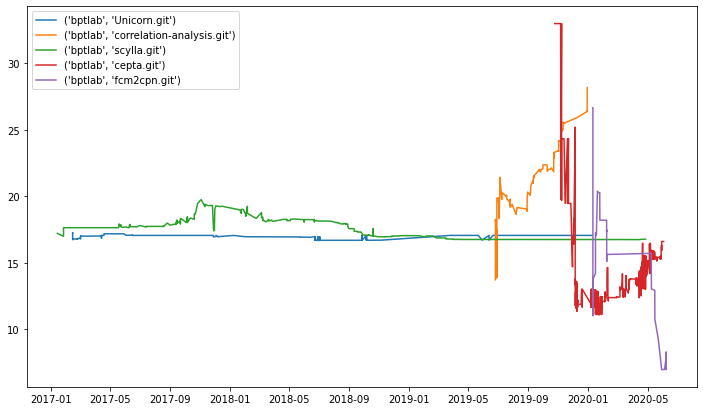

In [32]:
simpleRunMetric(locmOf)

Time used for ('bptlab', 'fcm2cpn.git'): 0.2428593635559082
Time used for ('bptlab', 'correlation-analysis.git'): 5.369837522506714
Time used for ('bptlab', 'scylla.git'): 23.692981958389282
Time used for ('json-iterator', 'java.git'): 25.463353395462036
Time used for ('bptlab', 'cepta.git'): 50.5887086391449
Time used for ('bptlab', 'Unicorn.git'): 52.17696785926819
Total Time used: 52.98057174682617


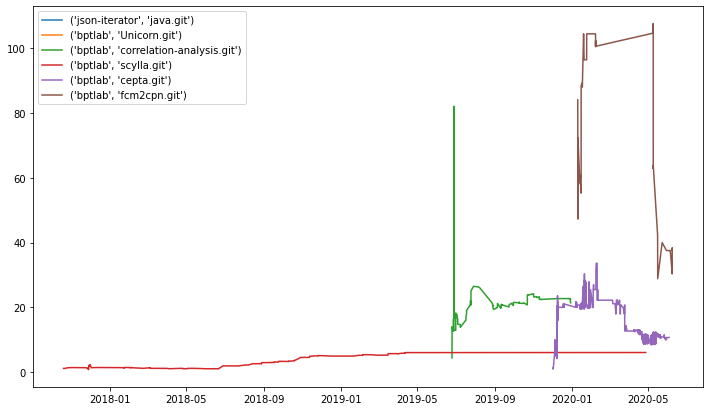

In [38]:
simpleRunMetric(lambdaDensity)

Time used for ('Elena-Zhao', 'Guimi.git'): 0.1284182071685791
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 0.10931038856506348
Time used for ('pleonex', 'ChatRMI.git'): 0.1066889762878418
Time used for ('craigslist206', 'huffman.git'): 0.16383004188537598
Time used for ('Elena-Zhao', 'Weibao.git'): 0.24792146682739258
Time used for ('pleonex', 'CocoKiller.git'): 0.2406604290008545
Time used for ('miken22', '304-Project.git'): 0.24741840362548828
Time used for ('bptlab', 'fcm2cpn.git'): 0.2866392135620117
Time used for ('pleonex', 'NiKate-Origins.git'): 0.39778637886047363
Time used for ('JTReed', 'Porygon.git'): 0.21101975440979004
Failed to analyze ('braliar', 'jabref.git'): Reference at 'refs/heads/master' does not exist
Time used for ('tyler124', 'Monitordroid.git'): 0.23861050605773926
Time used for ('GourdErwa', 'jasper_sample.git'): 0.2540762424468994
Time used for ('JTReed', 'Porygon2.git'): 0.4825553894042969
Time used for ('shengnwen', 'WeiBaoSSE.git'): 0.5534257888793945

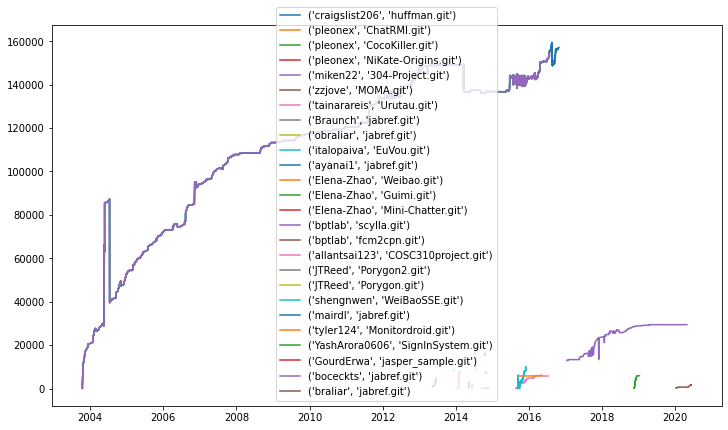

In [62]:
simpleRunMetric(loc, identity)

In [63]:
print(hasRepo('braliar','jabref'))
repo = getRepo('boceckts', 'jabref')
commit = next(repo.iter_commits())
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        print(obj.name)
        content = obj.data_stream.read().decode("CP437")
        metric = loc(content)

True
MacAdapter.java
BibDatabaseContext.java
Defaults.java
Globals.java
JabRefException.java
JabRefExecutorService.java
JabRefGUI.java
JabRefMain.java
MetaData.java
ArchitectureTests.java
BibDatabaseContextTest.java
BibtexTestData.java
FileBasedTestCase.java
FileBasedTestHelper.java
JabRefPreferencesTest.java
MetaDataTest.java
SearchQueryHighlightListenerTest.java
TestIconsProperties.java
AWTExceptionHandler.java
AbstractUITest.java
EntryTableTest.java
GUITest.java
UndoTest.java
Benchmarks.java
ArgumentProcessor.java
AuxCommandLine.java
JabRefCLI.java
Change.java
ChangeDisplayDialog.java
ChangeScanner.java
EntryAddChange.java
EntryChange.java
EntryDeleteChange.java
FileUpdateListener.java
FileUpdateMonitor.java
FileUpdatePanel.java
GroupChange.java
InfoPane.java
MetaDataChange.java
PreambleChange.java
StringAddChange.java
StringChange.java
StringNameChange.java
StringRemoveChange.java
AttachFileAction.java
AutoSetLinks.java
ConfirmCloseFileListEntryEditor.java
DownloadExternalFile.java

# Now bringing the user in

In [11]:
def isJavaFile(gitObject):
    return gitObject.type == 'blob' and gitObject.name.endswith('.java')

In [12]:
def isJavaRepo(repoTuple):
    try:
        (user, project) = repoTuple
        repo = getRepo(user, project)
        commit = list(repo.iter_commits())[0]
        return any(isJavaFile(obj) for obj in commit.tree.traverse())
    except Exception as e:
        print('Failed to check '+str(repoTuple)+': '+str(e))
        return False

In [153]:
# Delete all the duplicates except the newest
for (user, repo) in repoLibrarian.managedRepos():
    if repo.endswith('jabref.git') and not 'mairdl' in user:
        deleteRepo(user, repo)

Deleted repo "Braunch/jabref.git"
Deleted repo "obraliar/jabref.git"
Deleted repo "ayanai1/jabref.git"
Deleted repo "boceckts/jabref.git"


In [13]:
basicJavaRepos = list(filter(isJavaRepo, repoLibrarian.managedRepos()))
for x in basicJavaRepos: print(x)

Failed to check ('GourdErwa', 'my_note.git'): Reference at 'refs/heads/master' does not exist
('MarioLizana', 'RadioControlSED.git')
('craigslist206', 'huffman.git')
('pleonex', 'ChatRMI.git')
('pleonex', 'CocoKiller.git')
('pleonex', 'NiKate-Origins.git')
('pleonex', 'locaviewer.git')
('miken22', '304-Project.git')
('NeebalLearningPvtLtd', 'InventoryManagementSystem.git')
('zzjove', 'MOMA.git')
('tainarareis', 'Urutau.git')
('italopaiva', 'EuVou.git')
('ShutUpPaulo', 'TecProg_2016-01.git')
('andrevctr12', 'PAA_HUFFMAN.git')
('Elena-Zhao', 'Weibao.git')
('Elena-Zhao', 'MOMA.git')
('Elena-Zhao', 'Database-Auto-troubleshooting.git')
('Elena-Zhao', 'Guimi.git')
('Elena-Zhao', 'Mini-Chatter.git')
('alstonlo', 'Chat-Software-Assignment.git')
('alstonlo', 'Bongo-Cat-Attacc.git')
('dataspy', 'surprise-theory.git')
('ieeeugrsb', 'ieeextreme8.git')
('bptlab', 'scylla.git')
('bptlab', 'fcm2cpn.git')
('allantsai123', 'COSC310project.git')
('JTReed', 'Porygon2.git')
('JTReed', 'Porygon.git')
('she

In [22]:
import collections
def averageMetricPerCommitForRepo(repoTuple, metricFunction, fileCountConsumer = safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    commitToMetric = collections.OrderedDict()
    try:
        start = time.time()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            for obj in commit.tree.traverse():
                if isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    metric = metricFunction(content)
                    aggregatedMetric = aggregatedMetric + metric
            #commitToMetric[commit] = fileCountConsumer(aggregatedMetric, fileCount)
            commitToMetric[commit.hexsha] = (fileCountConsumer(aggregatedMetric, fileCount))
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return (commitToMetric)

In [15]:
def deltasOf(metricPerCommit):
    deltas = collections.OrderedDict()
    for (commit, metric) in metricPerCommit.items():
        if(len(commit.parents) == 1): #No merges or orphans(initial commit)
            parentMetric = metricPerCommit[commit.parents[-1]]
            deltas[commit] = metric - parentMetric
    return deltas

In [16]:
def plotByDate(data):
    dates = matplotlib.dates.epoch2num(list(map(lambda commit : commit.committed_date, data.keys())))
    pyplot.plot_date(dates, list(data.values()), '-')

In [17]:
def plotByLifecycle(data):
    if len(data) == 0:
        pyplot.plot([], [])
        return
    maxDate = next(iter(data)).committed_date
    minDate = next(reversed(data)).committed_date
    interval = maxDate - minDate
    dates = list(map(lambda commit : (commit.committed_date - minDate) / interval, data.keys()))
    pyplot.plot(dates, list(data.values()), '-')

In [169]:
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), locmOf)

Time used for ('bptlab', 'scylla'): 41.987555503845215


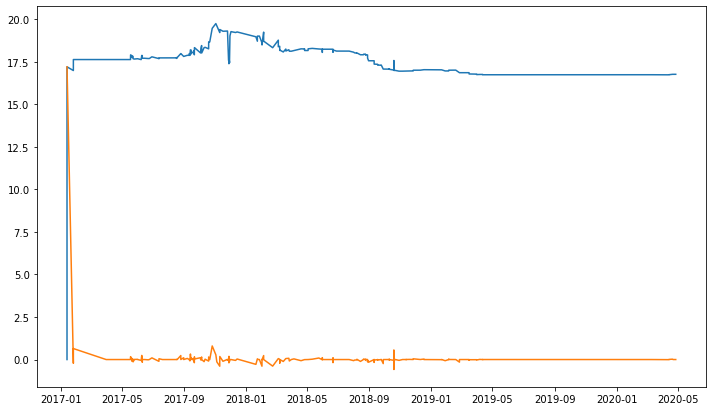

In [170]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data)
plotByDate(deltas)

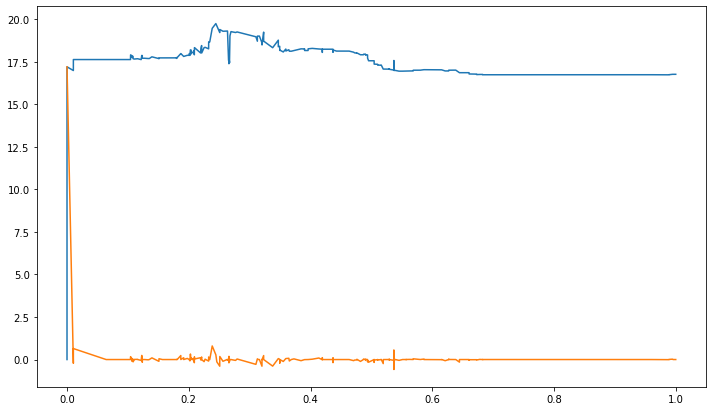

In [171]:
pyplot.figure(figsize=(12, 7))
plotByLifecycle(data)
plotByLifecycle(deltas)

In [179]:
### Run metrics for all repos

In [23]:
from multiprocessing.pool import ThreadPool


start = time.time()
with ThreadPool(int(multiprocessing.cpu_count()/4)) as pool:
    allMetrics = pool.map(lambda repo: averageMetricPerCommitForRepo(repoTuple=repo, metricFunction=locmOf), basicJavaRepos)
end = time.time()
print('Total Time used: '+str(end - start))

Time used for ('MarioLizana', 'RadioControlSED.git'): 2.288872003555298
Time used for ('Elena-Zhao', 'Database-Auto-troubleshooting.git'): 1.1933259963989258
Time used for ('pleonex', 'ChatRMI.git'): 2.6149213314056396
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 1.0597152709960938
Time used for ('Elena-Zhao', 'MOMA.git'): 2.895343065261841
Time used for ('Elena-Zhao', 'Guimi.git'): 1.6586320400238037
Time used for ('andrevctr12', 'PAA_HUFFMAN.git'): 3.767286777496338
Time used for ('craigslist206', 'huffman.git'): 4.9633095264434814


KeyboardInterrupt: 

Time used for ('ieeeugrsb', 'ieeextreme8.git'): 10.296770572662354
Time used for ('Elena-Zhao', 'Weibao.git'): 14.986135482788086
Time used for ('pleonex', 'CocoKiller.git'): 20.345555543899536
Time used for ('miken22', '304-Project.git'): 20.092790126800537
Time used for ('bptlab', 'fcm2cpn.git'): 19.116474628448486
Time used for ('dataspy', 'surprise-theory.git'): 22.40047836303711
Time used for ('pleonex', 'NiKate-Origins.git'): 30.12696361541748
Time used for ('alstonlo', 'Chat-Software-Assignment.git'): 27.567008018493652


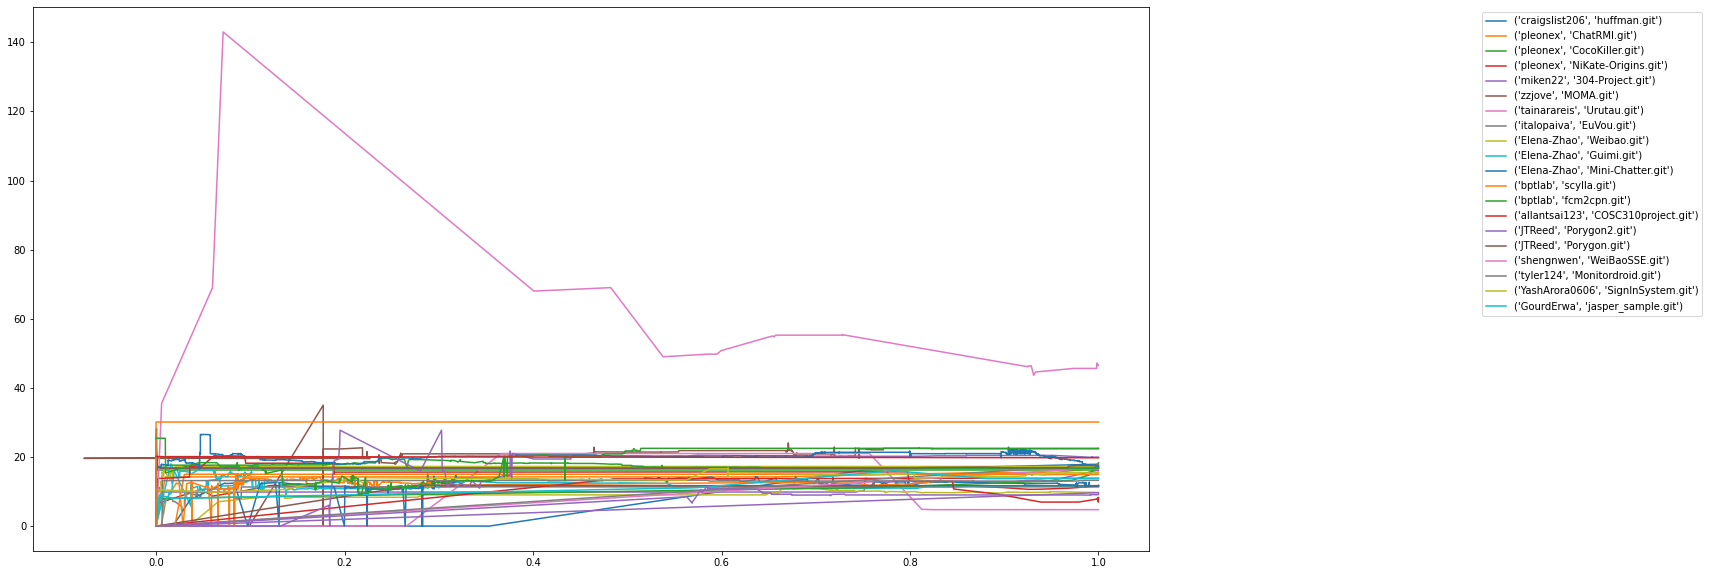

In [182]:
reposToMetrics = dict(zip(repos, allMetrics))

pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(data)

pyplot.legend(repos, bbox_to_anchor=(1.5, 1.0))

In [116]:
%load_ext autoreload
%aimport dbUtils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
utils.runQuery('''
    SELECT * FROM crm20.lb_polyglots
    ORDER BY secloc DESC
''')

Time used: 0.0024580955505371094


,author_id,javaloc,javastart,secondary_languages,secloc,secstart
0,5080586,42824,2014-08-25 10:38:05,[js],[18614],[2014-09-16 14:15:56]
1,69602,149818,2012-07-06 20:21:47,[js],[14102],[2012-11-16 18:22:57]
2,2725277,31015,2014-05-28 08:19:28,[js],[9449],[2014-06-07 08:30:32]
3,1979246,34247,2013-06-06 05:28:21,[js],[7991],[2013-06-10 07:17:46]
4,4908425,13493,2014-08-15 04:49:30,[js],[5306],[2015-09-27 06:27:28]
5,10328444,48735,2016-03-09 21:08:22,[py],[4419],[2016-09-08 14:13:20]
6,43901060,20794,2018-11-16 16:03:14,[js],[4006],[2018-12-11 02:28:36]
7,1275950,79795,2014-01-21 13:25:31,[py],[3020],[2014-03-29 16:39:49]
8,3242981,20263,2014-01-30 16:13:29,[js],[2296],[2014-11-08 16:28:25]
9,2200247,18317,2014-09-10 21:07:58,[py],[2234],[2014-10-09 18:11:46]


In [113]:
testUser = utils.runQuery('''
    SELECT * FROM crm20.lb_polyglots
    ORDER BY secloc DESC
''')['author_id'][0]
print(testUser)

Time used: 0.002789735794067383


5080586


In [114]:
testUserRepos = utils.runQuery('''
    SELECT DISTINCT url
    FROM ght.project_members, ght.projects
    WHERE user_id = {}
    AND repo_id = id
    AND language = 'Java'
'''.format(testUser))
display(testUserRepos)

Time used: 0.283855676651001


,url
0,https://api.github.com/repos/GourdErwa/jasper_...
1,https://api.github.com/repos/GourdErwa/my_note


Repo unavailable: ('GourdErwa', 'my_note.git')


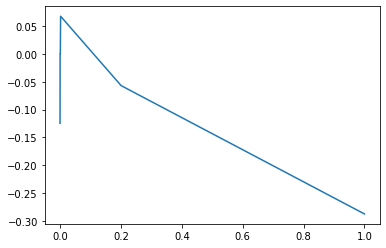

In [115]:
all = []
for url in testUserRepos['url']:
    split = url.split('/')
    user = split[-2]
    project = split[-1]+'.git'
    key = (user, project)
    if key in reposToMetrics:
        metrics = reposToMetrics[key]
        deltas = deltasOf(metrics)
        all.extend(deltas.items())
        #all.extend(metrics.items())
    else:
        print('Repo unavailable: '+str(key))
all.sort(key = lambda tup: tup[0].committed_date, reverse=True)
all = dict(all)
plotByLifecycle(all)

In [94]:
testUserRepos

,url
0,https://api.github.com/repos/Elena-Zhao/Guimi
1,https://api.github.com/repos/Elena-Zhao/Mini-C...
2,https://api.github.com/repos/Elena-Zhao/Weibao
3,https://api.github.com/repos/shengnwen/WeiBaoSSE
4,https://api.github.com/repos/zzjove/MOMA


In [183]:
masterMap = collections.ChainMap(allMetrics)

In [194]:
repo = getRepo('bptlab', 'scylla')
commit = list(repo.iter_commits())[0]

In [195]:
reposToMetrics[('bptlab', 'scylla.git')][commit]

KeyError: <git.Commit "ee00a205a2225ad73b0264cf7ba64be5c7044d0b">

In [189]:
sha = shaToCommit[commit.hexsha]
masterMap[commit.hexsha]

TypeError: list indices must be integers or slices, not str